# pyGIMLi(empymod)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli
import empymod

rng = np.random.default_rng()

## Create survey, model, and data

In [2]:
# Survey: Offsets and Frequencies
offsets = np.linspace(1000, 20000, 101)
frequencies = [0.1, 0.3, 1, 3]

# Model depths and resistivities
depth = [0, 1000, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]
mtrue = [2e14, 0.3, 1, 1, 1, 1, 1, 100, 1, 1, 1, 1, 1, 1]
m0 = [2e14, 0.3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Collect input parameters
inp = {
    'src': [-100, 100, 0, 0, 900, 900],
    'rec': [offsets, np.zeros(offsets.shape), 1000, 0, 0],
    'depth': depth,
    'freqtime': frequencies,
    'verb': 1,
}

# Create observed data and background == start model data
dobs = empymod.bipole(res=mtrue, **inp)
d0 = empymod.bipole(res=m0, **inp)

### Add noise to `dobs`
=> The following cell should go into `empymod`, or use `emg3d`, where it is already implemented

In [3]:
noise_floor = 1e-17
relative_error = 0.01
mean_noise = 0.0

# Exclude data below half the noise_floor
cut_data = abs(dobs) < (noise_floor / 2)
dobs[cut_data] = np.nan + 1j*np.nan
d0[cut_data] = np.nan + 1j*np.nan

# Add random white noise to dobs
std_dev = np.sqrt(noise_floor**2 + np.abs(relative_error*dobs)**2)
noise = std_dev * ((1+1j)*mean_noise + np.exp(1j * rng.uniform(0, 2*np.pi, dobs.shape)))
dobs += noise

## QC model and data

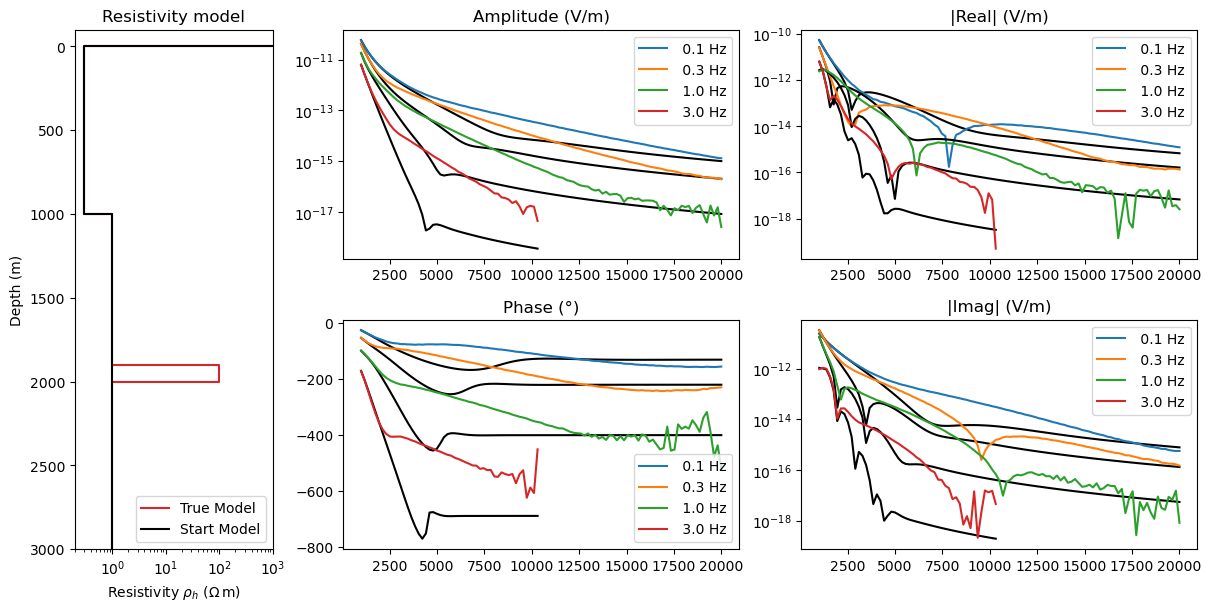

In [4]:
# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

p_mtrue = np.repeat(mtrue, 2)
p_m0 = np.repeat(m0, 2)
p_depth = np.r_[-100, np.repeat(depth, 2), 3000]

# Plot Resistivities
ax1.set_title('Resistivity model')
ax1.plot(p_mtrue, p_depth, 'C3', label="True Model")
ax1.plot(p_m0, p_depth, 'k', label="Start Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([depth[-1]+500, depth[0]-100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(frequencies):
    ax2.plot(offsets, d0[i, :].amp(), 'k')
    ax2.plot(offsets, dobs[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(frequencies):
    ax4.plot(offsets, d0[i, :].pha(deg=True), 'k')
    ax4.plot(offsets, dobs[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(frequencies):
    ax3.plot(offsets, abs(d0[i, :].real), 'k-')
    ax3.plot(offsets, abs(dobs[i, :].real), '-', label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(frequencies):
    ax5.plot(offsets, abs(d0[i, :].imag), 'k-')
    ax5.plot(offsets, abs(dobs[i, :].imag), '-', label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

## Forward Kernel and modified Inversion class
=> The following cell should go into `empymod.inv.pygimli`

In [5]:
class Kernel(pygimli.Modelling):
    
    def __init__(self, input_map, routine=empymod.bipole):
        """Initialize the model."""
        super().__init__()

        # Store inputs
        self.input_map = input_map
        self.routine = routine
        
    def response(self, x):
        """Forward response."""    

        # Compute responses
        em = self.routine(**self.input_map(x))
        
        # Ravel output, taking care of complex values
        em = np.r_[em.ravel().real, em.ravel().imag if np.iscomplexobj(em) else []]

        # Return required data
        return em if not hasattr(self, 'indices') else em[self.indices]
    
    def createStartModel(self, dataVals=None):
        """Overwrite default method with an Error.""" 
        raise NotImplementedError("Start Model must be provided.")


class Inversion(pygimli.Inversion):
    
    def run(self, dataVals, errorVals=None, **kwargs):

        # Store the mesh (pseudo)
        if "startModel" in kwargs:
            n_model = len(np.atleast_1d(kwargs["startModel"]))
        else:
            n_model = len(self.startModel)
        self.fop.mesh1d = pygimli.meshtools.createMesh1D(n_model)
        self.fop.setMesh(self.fop.mesh1d)

        # Error: Same as in original function, but taking care of complex data
        if errorVals is None:  # use absoluteError and/or relativeError instead
            absErr = kwargs.pop("absoluteError", 0)
            relErr = kwargs.pop("relativeError",
                                0.01 if np.allclose(absErr, 0) else 0)
            errorVals = abs(absErr / np.asarray(abs(dataVals))) + relErr

        if isinstance(errorVals, (float, int)):
            errorVals = np.ones_like(dataVals.real) * errorVals
        
        # Ravel data and decompose complex data
        d_size = dataVals.size
        d_shape = dataVals.shape
        is_complex = False
        if np.iscomplexobj(dataVals):
            is_complex = True
            d_size *= 2
        dataVals = np.r_[dataVals.ravel().real, dataVals.ravel().imag if is_complex else []]
        errorVals = np.r_[errorVals.ravel(), errorVals.ravel() if is_complex else []]

        # Limit to finite values
        if np.any(~np.isfinite(dataVals)):
            self.fop.indices = np.isfinite(dataVals)
            dataVals = dataVals[self.fop.indices]
            errorVals = errorVals[self.fop.indices]

        # Run the inversion
        model = super().run(dataVals=dataVals, errorVals=errorVals, **kwargs)

        # Reshape data           
        if hasattr(self.fop, 'indices'):
            out = np.ones(d_size)*np.nan
            out[self.fop.indices] = np.array(self.response)
        else:
            out = np.array(self.response)
        if is_complex:
            out = out[:d_size//2] + 1j*out[d_size//2:]               
        response = empymod.EMArray(np.reshape(out, d_shape))

        # Return mapped parameters and response
        return self.fop.input_map(model), response

## Inversion

In [6]:
%%time

def input_map(x, inp=inp):
    """Map the inversion parameter to modelling parameters."""
    # Could be res, aniso, depth, a mixture of it, ...
    inp['res'] =  np.r_[2e14, 0.3, x]
    return inp

fop = Kernel(input_map, empymod.bipole)
inv = Inversion(fop=fop)

# Not Sure Yet How To Use These
#inv.dataTrans = pygimli.trans.TransSymLog(1e-20)
#inv.transModel = pygimli.trans.TransLog(0.1) # > 1 Ohmm

out, response = inv.run(
    dataVals=dobs,
    absoluteError=std_dev,
    #relativeError=0.01,
    startModel=m0[2:],
    verbose=True
)

# Get inversion result from parameter dict
# Could be res, aniso, depth, ...
minv = out['res']

21/02/24 - 17:24:46 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 2.64703e+11/1.01e+14
fop: <__main__.Kernel object at 0x7fb4a843f860>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fb4a9c6b580>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fb4a843f8b0>
min/max (data): -3.2e-11/5.1e-11
min/max (error): 0.99%/378%
min/max (start model): 1/1
--------------------------------------------------------------------------------
min/max(dweight) = 2.64703e+11/1.01e+14
Building constraints matrix
constraint matrix of size(nBounds x nModel) 11 x 12
check Jacobian: wrong dimensions: (0x0) should be (706x12)  force: 1
jacobian size invalid, forced recalc: 1
inv.iter 0 ... chi² = 155076.74calculating jacobian matrix (forced=1)...Create Jacobian matrix (brute force) ... ... 2.439 s.
... 2.63036 s
min data = -3.21287e-11 max data = 5.12616e-11 (706)
min error = 0.00990101 max error = 3.77782 (706)
min response = -3.29052e-11 max response = 5.24701e-11 (706)
calc without reference model
0: rms/rrms(data, response) = 1.54

## Plot result

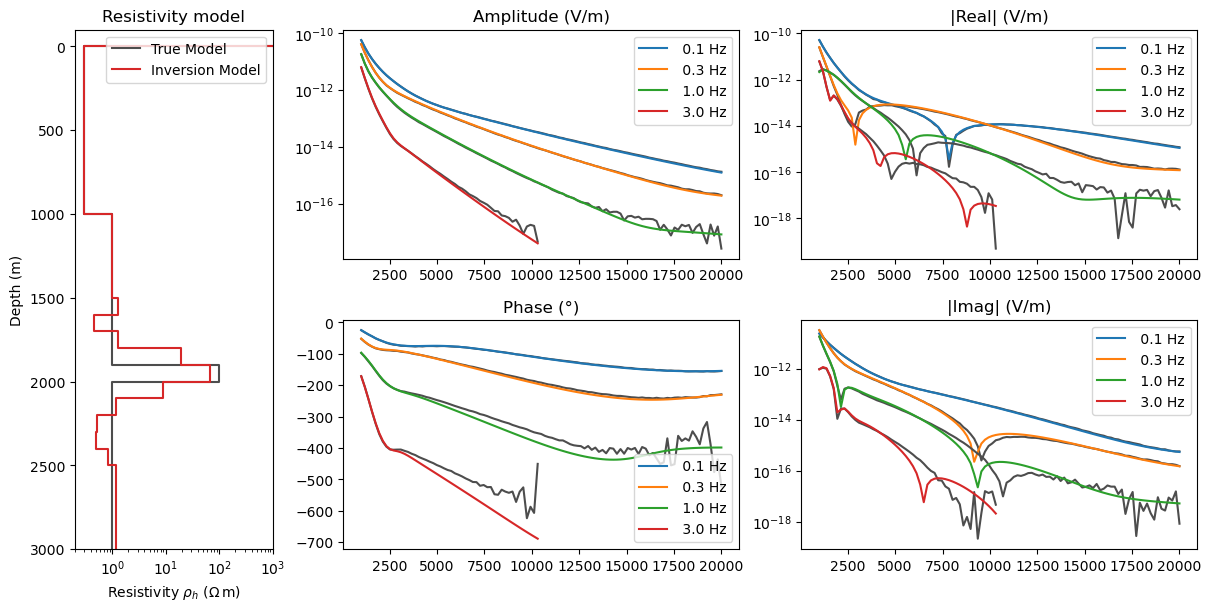

In [7]:
# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

p_minv = np.repeat(minv, 2)

# Plot Resistivities
ax1.set_title('Resistivity model')
#ax1.plot(p_m0, p_depth, 'k', label="Start Model")
ax1.plot(p_mtrue, p_depth, '.3', label="True Model")
ax1.plot(p_minv, p_depth, 'C3', label="Inversion Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([depth[-1]+500, depth[0]-100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(frequencies):
    #ax2.plot(offsets, d0[i, :].amp(), 'k')
    ax2.plot(offsets, dobs[i, :].amp(), '.3')
    ax2.plot(offsets, response[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(frequencies):
    #ax4.plot(offsets, d0[i, :].pha(deg=True), 'k')
    ax4.plot(offsets, dobs[i, :].pha(deg=True), '.3')
    ax4.plot(offsets, response[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(frequencies):
    #ax3.plot(offsets, abs(d0[i, :].real), 'k')
    ax3.plot(offsets, abs(dobs[i, :].real), '.3')
    ax3.plot(offsets, abs(response[i, :].real), label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(frequencies):
    #ax5.plot(offsets, abs(d0[i, :].imag), 'k')
    ax5.plot(offsets, abs(dobs[i, :].imag), '.3')
    ax5.plot(offsets, abs(response[i, :].imag), label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

In [8]:
empymod.Report(['pyGIMLi', 'pgcore'])

--------------------------------------------------------------------------------
  Date: Wed Feb 21 17:25:00 2024 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:44:36)
  [GCC 12.3.0]

           pyGIMLi : 1.4.5
            pgcore : 1.4.0
             numpy : 1.23.5
             scipy : 1.10.1
             numba : 0.58.1
           empymod : 2.2.2
           IPython : 8.12.2
        matplotlib : 3.7.3
--------------------------------------------------------------------------------